In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# Suppress TensorFlow warnings related to CUDA libraries registration
import os
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image as kp_image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-11 08:40:57.884828: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 08:40:57.884951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 08:40:58.053951: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:

# Define paths for content and style images
content_image_dir = '/kaggle/input/imagenet/imagenet/train'
style_image_dir = '/kaggle/input/best-artworks-of-all-time/images/images'

# Load and preprocess images
def load_and_process_img(path_to_img):
    img = Image.open(path_to_img)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((224, 224))
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Define the NST model
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

def get_style_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    model_outputs = content_outputs + style_outputs
    return Model(vgg.input, model_outputs)

# Define loss functions
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    model_outputs = model(init_image)
    content_output_features = model_outputs[:len(content_features)]
    style_output_features = model_outputs[len(content_features):]
    content_loss = tf.add_n([get_content_loss(content_features[i], content_output_features[i])
                             for i in range(len(content_features))])
    style_loss = tf.add_n([get_style_loss(style_output_features[i], gram_style_features[i])
                           for i in range(len(style_output_features))])
    content_loss *= loss_weights[0]
    style_loss *= loss_weights[1]
    total_loss = content_loss + style_loss
    return total_loss


In [1]:

# Define training step
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss
    return tape.gradient(total_loss, cfg['init_image']), all_loss

def run_style_transfer(content_img_path, style_img_path, num_iterations=800, content_weight=1e3, style_weight=1e-2): 
    model = get_style_model()
    for layer in model.layers:
        layer.trainable = False
    content_image = load_and_process_img(content_img_path)
    style_image = load_and_process_img(style_img_path)
    style_features = [style_layer[0] for style_layer in model(style_image)[len(content_layers):]]
    content_features = [content_layer[0] for content_layer in model(content_image)[:len(content_layers)]]
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)
    iter_count = 1

    best_loss, best_img = float('inf'), None
    loss_weights = (content_weight, style_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)

        if all_loss < best_loss:
            best_loss = all_loss
            best_img = deprocess_img(init_image.numpy())
            
        #if i % 100 == 0:
            #print(f'Iteration: {i}, Total loss: {all_loss:.4e}')

    return best_img, best_loss

# Load content and style images
content_images = glob.glob(os.path.join(content_image_dir, '*.JPEG'))
style_images = glob.glob(os.path.join(style_image_dir, '**/*.jpg'), recursive=True)

# Ensure there are content and style images
assert len(content_images) > 0, "No content images found."
assert len(style_images) > 0, "No style images found."

# Perform style transfer for a batch of images
output_dir = 'output_images'
os.makedirs(output_dir, exist_ok=True)

stylized_images = []
content_image_samples = []
style_image_samples = []
# Create stylized images with multiple styles for each content image
num_styles_per_content = 5


output_dir = 'output_stylized_images2'
os.makedirs(output_dir, exist_ok=True)

for i, content_img_path in enumerate(content_images[:20]):
    for _ in range(num_styles_per_content):
        style_img_path = random.choice(style_images)
        content_image_samples.append(content_img_path)
        style_image_samples.append(style_img_path)
        print(f'image:{i} Stylizing {content_img_path} with {style_img_path}')
        best_img, best_loss = run_style_transfer(content_img_path, style_img_path)
        output_img = Image.fromarray(best_img)
        output_img.save(os.path.join(output_dir, f'stylized_image_{i}_{_}.jpg'))
        stylized_images.append(best_img)

print(f'Stylized images saved to {output_dir}')


2024-06-11 07:41:29.101368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 07:41:29.101460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 07:41:29.253541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


image:0 Stylizing /kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00021211.JPEG with /kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas/Edgar_Degas_132.jpg
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
image:0 Stylizing /kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00021211.JPEG with /kaggle/input/best-artworks-of-all-time/images/images/Rene_Magritte/Rene_Magritte_29.jpg
image:0 Stylizing /kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00021211.JPEG with /kaggle/input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_91.jpg
image:0 Stylizing /kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00021211.JPEG with /kaggle/input/best-artworks-of-all-time/images/images/Jan_van_Eyck/Jan_van_Eyck_75.jpg
image:0 Stylizing /kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00021211.JPEG with /kaggle/input/best-artworks-of-all-time/images/images/Salvador_Dali/Salvador_Dali_59.jpg
image:1 Stylizing /kaggle/input/imagenet/im

In [2]:
import zipfile
zip_filename = 'output_stylized_images.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))

print(f'Output images zipped to {zip_filename}')

Output images zipped to output_stylized_images.zip


In [3]:

content_image_samples = [
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00021211.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00045098.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00041245.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00020370.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00029391.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00026689.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00013507.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00039848.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00010484.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00046886.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00007995.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00038821.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00015192.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00022053.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00043019.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00016282.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00010112.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00016079.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00015621.JPEG",
    "/kaggle/input/imagenet/imagenet/train/ILSVRC2012_val_00038855.JPEG"
]

style_image_samples = [
    "/kaggle/input/best-artworks-of-all-time/images/images/Rene_Magritte/Rene_Magritte_29.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_161.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Henri_Matisse/Henri_Matisse_120.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Diego_Rivera/Diego_Rivera_56.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas/Edgar_Degas_13.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Vincent_van_Gogh/Vincent_van_Gogh_807.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Rembrandt/Rembrandt_120.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Mikhail_Vrubel/Mikhail_Vrubel_166.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_272.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas/Edgar_Degas_326.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Vincent_van_Gogh/Vincent_van_Gogh_572.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Vincent_van_Gogh/Vincent_van_Gogh_576.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas/Edgar_Degas_62.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley/Alfred_Sisley_70.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Alfred_Sisley/Alfred_Sisley_42.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Gustave_Courbet/Gustave_Courbet_25.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas/Edgar_Degas_533.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Titian/Titian_22.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Edgar_Degas/Edgar_Degas_614.jpg",
    "/kaggle/input/best-artworks-of-all-time/images/images/Rene_Magritte/Rene_Magritte_29.jpg"
]


In [7]:
import os
output_dir = "/kaggle/input/output-stylized-images"
stylized_images = []

for filename in os.listdir(output_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(output_dir, filename)
        img = Image.open(img_path)
        stylized_images.append(img)

In [18]:
len(negative_pairs)

180

/tmp/ipykernel_198/2539487035.py:49: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', pooling='avg')


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation accuracy: 0.6731
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        36
           1       0.44      0.25      0.32        16

    accuracy                           0.67        52
   macro avg       0.58      0.56      0.55        52
weighted avg       0.64      0.67      0.64        52



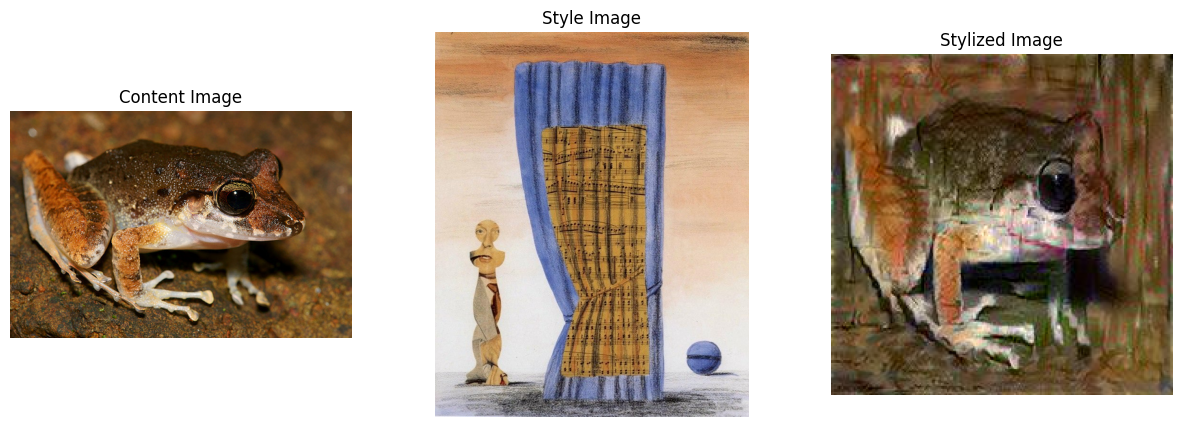

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
content_images_processed = [load_and_process_img(img_path) for img_path in content_image_samples]
stylized_images = np.array(stylized_images)
content_images = np.array([deprocess_img(img) for img in content_images_processed])

# Create positive and negative samples for contrastive learning
positive_pairs = []
negative_pairs = []
num_styles_per_content=5
# Positive samples: Same image with different styles
for i in range(0, len(content_images), num_styles_per_content):
    for j in range(num_styles_per_content):
        for k in range(j + 1, num_styles_per_content):
            positive_pairs.append((content_images[i], stylized_images[i + j]))
            positive_pairs.append((content_images[i], stylized_images[i + k]))

# Negative samples: Different images with the same style and different images with different styles
for i in range(0, len(content_images), num_styles_per_content):
    for j in range(num_styles_per_content):
        for k in range(i + num_styles_per_content, len(content_images), num_styles_per_content):
            negative_pairs.append((content_images[i], stylized_images[k + j]))  # Different content, same style
            for l in range(num_styles_per_content):
                negative_pairs.append((content_images[i], stylized_images[k + l]))  # Different content and style

# Shuffle and split the data
pairs = positive_pairs + negative_pairs
labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

pairs, labels = shuffle(np.array(pairs), np.array(labels), random_state=42)
X_train, X_val, y_train, y_val = train_test_split(pairs, labels, test_size=0.2, random_state=42)

# Define the preprocess_images function
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = tf.image.resize(img, (224, 224))
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
        processed_images.append(img)
    return np.array(processed_images)

# Extract features using MobileNetV2
mobilenet = MobileNetV2(include_top=False, weights='imagenet', pooling='avg')

def extract_features(images):
    features = mobilenet.predict(images,batch_size=16)
    return features

# Prepare images for feature extraction
train_images = np.concatenate([X_train[:, 0], X_train[:, 1]])
val_images = np.concatenate([X_val[:, 0], X_val[:, 1]])

# Extract features
train_features = extract_features(preprocess_images(train_images))
val_features = extract_features(preprocess_images(val_images))

# Create feature pairs
train_features = train_features.reshape(-1, 2, train_features.shape[-1])
val_features = val_features.reshape(-1, 2, val_features.shape[-1])

train_diff = np.abs(train_features[:, 0] - train_features[:, 1])
val_diff = np.abs(val_features[:, 0] - val_features[:, 1])

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(train_diff, y_train)

# Evaluate the classifier
y_pred = clf.predict(val_diff)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy:.4f}')
print("Classification Report:")
print(classification_report(y_val, y_pred))

sample_index = 0  # Choose the index of the sample to display

content_img = Image.open(content_image_samples[sample_index])
style_img = Image.open(style_image_samples[sample_index])
stylized_img = Image.open(f'output_stylized_images2/stylized_image_{sample_index}_{sample_index % num_styles_per_content}.jpg')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display content image
axes[0].imshow(content_img)
axes[0].set_title('Content Image')
axes[0].axis('off')

# Display style image
axes[1].imshow(style_img)
axes[1].set_title('Style Image')
axes[1].axis('off')

# Display stylized image
axes[2].imshow(stylized_img)
axes[2].set_title('Stylized Image')
axes[2].axis('off')

plt.show()

In [13]:
# Prepare content and stylized images for processing
content_images_processed = [load_and_process_img(img_path) for img_path in content_image_samples]
stylized_images = np.array(stylized_images)
content_images = np.array([deprocess_img(img) for img in content_images_processed])

# Create positive and negative samples for contrastive learning
positive_pairs = []
negative_pairs = []

# Positive samples: Same image with different styles
for i in range(0, len(content_images), num_styles_per_content):
    for j in range(num_styles_per_content):
        for k in range(j + 1, num_styles_per_content):
            if (i + j) < len(stylized_images): 
                positive_pairs.append((content_images[i], stylized_images[i + j]))
            if (i + k) < len(stylized_images):  # Ensure the index is within bounds
                positive_pairs.append((content_images[i], stylized_images[i + k]))

# Negative samples: Different images with the same style and different images with different styles
for i in range(0, len(content_images), num_styles_per_content):
    for j in range(num_styles_per_content):
        for k in range(i + num_styles_per_content, len(content_images), num_styles_per_content):
            if (j + k) < len(stylized_images): 
                negative_pairs.append((content_images[i], stylized_images[k + j]))  # Different content, same style
            for l in range(num_styles_per_content):
                if (l + k) < len(stylized_images): 
                    negative_pairs.append((content_images[i], stylized_images[k + l]))  # Different content and style

# Shuffle and split the data
pairs = positive_pairs + negative_pairs
labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

pairs, labels = shuffle(np.array(pairs), np.array(labels), random_state=42)
X_train, X_val, y_train, y_val = train_test_split(pairs, labels, test_size=0.2, random_state=42)

# Extract features using MobileNetV2
mobilenet = MobileNetV2(include_top=False, weights='imagenet', pooling='avg')

def extract_features(images):
    features = mobilenet.predict(images,batch_size=16)
    return features

# Prepare images for feature extraction
train_images = np.concatenate([X_train[:, 0], X_train[:, 1]])
val_images = np.concatenate([X_val[:, 0], X_val[:, 1]])

# Extract features
train_features = extract_features(preprocess_images(train_images))
val_features = extract_features(preprocess_images(val_images))

# Create feature pairs
train_features = train_features.reshape(-1, 2, train_features.shape[-1])
val_features = val_features.reshape(-1, 2, val_features.shape[-1])

train_diff = np.abs(train_features[:, 0] - train_features[:, 1])
val_diff = np.abs(val_features[:, 0] - val_features[:, 1])

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(train_diff, y_train)

# Evaluate the classifier
y_pred = clf.predict(val_diff)
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy:.4f}')
print("Classification Report:")
print(classification_report(y_val, y_pred))

/tmp/ipykernel_198/215409315.py:37: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(include_top=False, weights='imagenet', pooling='avg')


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step
Validation accuracy: 0.6731
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        36
           1       0.44      0.25      0.32        16

    accuracy                           0.67        52
   macro avg       0.58      0.56      0.55        52
weighted avg       0.64      0.67      0.64        52



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
from tensorflow.keras.applications import VGG16
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the VGG16 model
vgg16 = VGG16(include_top=False, weights='imagenet', pooling='avg')

# Define a function to extract features using VGG16
def extract_features_vgg(images):
    features = vgg16.predict(images, batch_size=16)
    return features

# Prepare images for feature extraction
train_images = np.concatenate([X_train[:, 0], X_train[:, 1]])
val_images = np.concatenate([X_val[:, 0], X_val[:, 1]])

# Extract features using VGG16
train_features_vgg = extract_features_vgg(preprocess_images(train_images))
val_features_vgg = extract_features_vgg(preprocess_images(val_images))

# Create feature pairs
train_features_vgg = train_features_vgg.reshape(-1, 2, train_features_vgg.shape[-1])
val_features_vgg = val_features_vgg.reshape(-1, 2, val_features_vgg.shape[-1])

train_diff_vgg = np.abs(train_features_vgg[:, 0] - train_features_vgg[:, 1])
val_diff_vgg = np.abs(val_features_vgg[:, 0] - val_features_vgg[:, 1])

# Train a logistic regression classifier using VGG16 features
clf_vgg = LogisticRegression()
clf_vgg.fit(train_diff_vgg, y_train)

# Evaluate the classifier
y_pred_vgg = clf_vgg.predict(val_diff_vgg)
accuracy_vgg = accuracy_score(y_val, y_pred_vgg)
print(f'Validation accuracy using VGG16 features: {accuracy_vgg:.4f}')
print("Classification Report:")
print(classification_report(y_val, y_pred_vgg))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Validation accuracy using VGG16 features: 0.6346
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.92      0.78        36
           1       0.00      0.00      0.00        16

    accuracy                           0.63        52
   macro avg       0.34      0.46      0.39        52
weighted avg       0.47      0.63      0.54        52



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the ResNet50 model without the top (classification) layer
resnet = ResNet50(include_top=False, weights='imagenet', pooling='avg')

# Define a function to extract features using ResNet50
def extract_resnet_features(images):
    preprocessed_images = preprocess_input(images)
    features = resnet.predict(preprocessed_images, batch_size=16)
    return features

# Extract features for training and validation images
train_features_resnet = extract_resnet_features(train_images)
val_features_resnet = extract_resnet_features(val_images)

# Create feature pairs
train_features_resnet = train_features_resnet.reshape(-1, 2, train_features_resnet.shape[-1])
val_features_resnet = val_features_resnet.reshape(-1, 2, val_features_resnet.shape[-1])

# Calculate the absolute difference between feature vectors
train_diff_resnet = np.abs(train_features_resnet[:, 0] - train_features_resnet[:, 1])
val_diff_resnet = np.abs(val_features_resnet[:, 0] - val_features_resnet[:, 1])

# Train a logistic regression classifier
clf_resnet = LogisticRegression()
clf_resnet.fit(train_diff_resnet, y_train)

# Evaluate the classifier
y_pred_resnet = clf_resnet.predict(val_diff_resnet)
accuracy_resnet = accuracy_score(y_val, y_pred_resnet)
print(f'Validation accuracy using ResNet50 features: {accuracy_resnet:.4f}')
print("Classification Report:")
print(classification_report(y_val, y_pred_resnet))

# Plot the confusion matrix
conf_matrix_xgb = confusion_matrix(y_val, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (resnet50)')
plt.show()


In [26]:
import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Define a function to extract SIFT features from an image
def extract_sift_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    return keypoints, descriptors

# Extract SIFT features for training and validation images
train_keypoints = []
train_descriptors = []
val_keypoints = []
val_descriptors = []

for img in train_images:
    kp, des = extract_sift_features(img)
    train_keypoints.append(kp)
    train_descriptors.append(des)

for img in val_images:
    kp, des = extract_sift_features(img)
    val_keypoints.append(kp)
    val_descriptors.append(des)

# Match features using FLANN (Fast Approximate Nearest Neighbor Search Library)
flann_index_params = dict(algorithm=0, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(flann_index_params, search_params)

# Define a function to match SIFT descriptors
def match_sift_descriptors(des1, des2):
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    
    return len(good_matches)

# Calculate the number of matched SIFT descriptors for each pair of images
train_sift_matches = np.array([[match_sift_descriptors(train_descriptors[i], train_descriptors[j]) 
                                 for j in range(len(train_images))] 
                                for i in range(len(train_images))])

val_sift_matches = np.array([[match_sift_descriptors(val_descriptors[i], val_descriptors[j]) 
                               for j in range(len(val_images))] 
                              for i in range(len(val_images))])

# Flatten the matrix to use as features
train_sift_features = train_sift_matches.reshape(-1, len(train_images)**2)
val_sift_features = val_sift_matches.reshape(-1, len(val_images)**2)

# Train a logistic regression classifier
clf_sift = LogisticRegression()
clf_sift.fit(train_sift_features, y_train)

# Evaluate the classifier
y_pred_sift = clf_sift.predict(val_sift_features)
accuracy_sift = accuracy_score(y_val, y_pred_sift)
print(f'Validation accuracy using SIFT features: {accuracy_sift:.4f}')
print("Classification Report:")
print(classification_report(y_val, y_pred_sift))

# Plot the confusion matrix
conf_matrix_xgb = confusion_matrix(y_val, y_pred_sift)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (XGBoost)')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [1, 208]

XGBoost Validation accuracy: 0.5482
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.67      0.61       103
           1       0.53      0.41      0.47        94

    accuracy                           0.55       197
   macro avg       0.55      0.54      0.54       197
weighted avg       0.55      0.55      0.54       197



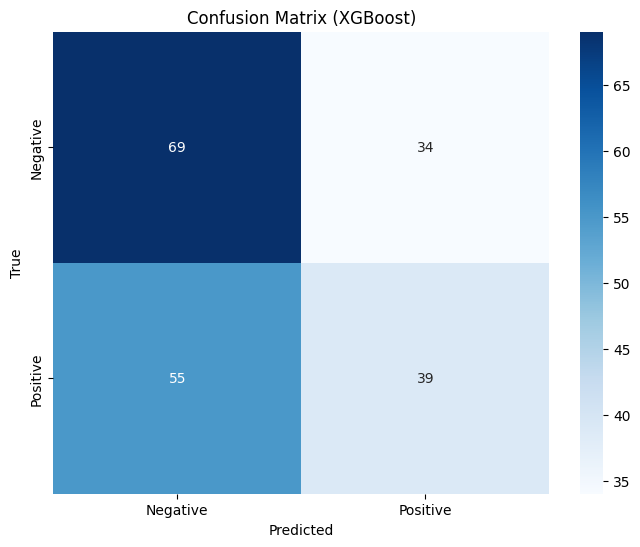

In [28]:
from xgboost import XGBClassifier

# Set the scale_pos_weight parameter to handle class imbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Train the XGBoost classifier with the scaled positive weight
xgb_clf = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_clf.fit(train_diff, y_train)

# Evaluate the classifier
y_pred_xgb = xgb_clf.predict(val_diff)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f'XGBoost Validation accuracy: {accuracy_xgb:.4f}')
print("XGBoost Classification Report:")
print(classification_report(y_val, y_pred_xgb))

# Plot the confusion matrix
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (XGBoost)')
plt.show()
